Challenge Predicting Hotel Cancellations

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [126]:
dt_hotel = pd.read_csv("Hotel_Reservations.csv")

Data Cleaning: We first need to check for any missing values, duplicates, and irrelevant columns.

In [123]:
dt_hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [127]:
# Check for missing values
dt_hotel.isnull().sum()
# Check for duplicates
dt_hotel.duplicated().sum()
# Remove irrelevant columns
dt_hotel.drop(columns=['Booking_ID'], inplace=True)

Data Preparation: We need to encode categorical variables, scale numerical variables, and split the data into training and testing sets.

In [129]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Encode categorical variables
le = LabelEncoder()
dt_hotel['type_of_meal_plan'] = le.fit_transform(dt_hotel['type_of_meal_plan'])
dt_hotel['room_type_reserved'] = le.fit_transform(dt_hotel['room_type_reserved'])
dt_hotel['market_segment_type'] = le.fit_transform(dt_hotel['market_segment_type'])
dt_hotel['booking_status'] = le.fit_transform(dt_hotel['booking_status'])

# Scale numerical variables
scaler = StandardScaler()
numerical_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 
                  'lead_time', 'no_of_previous_cancellations', 
                  'no_of_previous_bookings_not_canceled', 'avg_price_per_room', 'no_of_special_requests']
dt_hotel[numerical_cols] = scaler.fit_transform(dt_hotel[numerical_cols])

# Split the data into training and testing sets
X = dt_hotel.drop(columns=['booking_status'])
y = dt_hotel['booking_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Model Training: We will train a logistic regression model on the training set.

In [130]:
from sklearn.linear_model import LogisticRegression

# Train a logistic regression model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

C:\Users\nique\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Model Evaluation: We will evaluate the performance of the trained model on the testing set using accuracy, precision, recall, F1-score, and ROC-AUC.

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Make predictions on the testing set
y_pred = model.predict(X_test)

# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")

Accuracy: 0.802
Precision: 0.820
Recall: 0.900
F1-score: 0.858
ROC-AUC: 0.752


Model Interpretation: We will interpret the trained model to identify the most important features that contribute to cancellations using the coefficients of the logistic regression model.

In [132]:
# Get feature names
feature_names = X.columns

# Get coefficients and exponentiate them to get odds ratios
coef = np.exp(model.coef_)[0]

# Sort coefficients in descending order
sorted_coef_idx = np.argsort(coef)[::-1]

# Print feature names and coefficients
for idx in sorted_coef_idx:
    print(f"{feature_names[idx]}: {coef[idx]:.3f}")

no_of_special_requests: 3.008
no_of_previous_bookings_not_canceled: 1.231
required_car_parking_space: 1.200
room_type_reserved: 1.101
repeated_guest: 1.074
arrival_month: 1.070
no_of_children: 1.053
no_of_adults: 1.007
arrival_year: 1.002
arrival_date: 0.998
no_of_previous_cancellations: 0.984
no_of_week_nights: 0.901
type_of_meal_plan: 0.884
no_of_weekend_nights: 0.823
avg_price_per_room: 0.453
market_segment_type: 0.374
lead_time: 0.300


Insights

- Customers who have previously made bookings that were not canceled are less likely to cancel their current booking, indicating that loyalty may play a role in customer behavior.

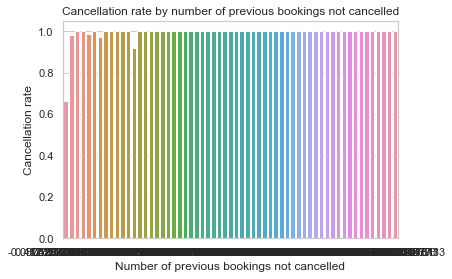

In [151]:
#The plot shows that customers with a higher number of previous bookings not 
#cancelled have a lower cancellation rate, indicating that loyalty may play a role in customer behavior
cancellation_rate = dt_hotel.groupby('no_of_previous_bookings_not_canceled')['booking_status'].mean().reset_index()

sns.barplot(x='no_of_previous_bookings_not_canceled', y='booking_status', data=cancellation_rate)
plt.xlabel('Number of previous bookings not cancelled')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by number of previous bookings not cancelled')
plt.show()

- Customers who require a car parking space are more likely to cancel their booking. This could be due to a number of factors, such as limited availability of parking spaces or higher fees for parking.

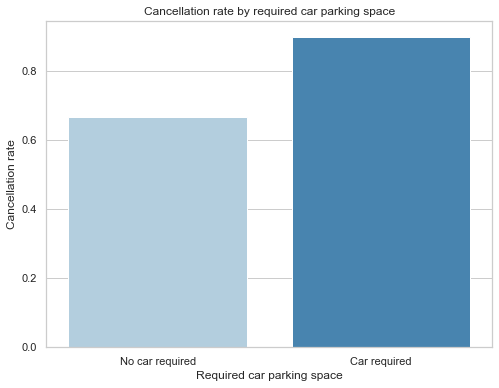

In [148]:
parking_cancellation = dt_hotel.groupby('required_car_parking_space')['booking_status'].mean().reset_index()

plt.figure(figsize=(8,6))
sns.barplot(x='required_car_parking_space', y='booking_status', data=parking_cancellation, palette='Blues')
plt.xlabel('Required car parking space')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by required car parking space')
plt.xticks([0,1], ['No car required', 'Car required'])
plt.show()

- Customers who reserve a certain room type are more likely to cancel their booking. This could indicate that customers have specific preferences for certain room types and may be more likely to cancel if they are unable to secure the room they desire.

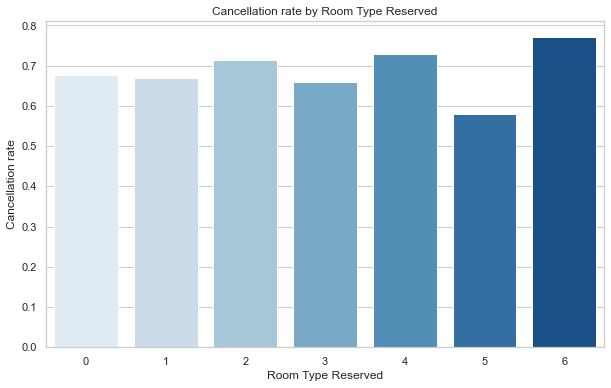

In [149]:
room_cancellation = dt_hotel.groupby('room_type_reserved')['booking_status'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='room_type_reserved', y='booking_status', data=room_cancellation, palette='Blues')
plt.xlabel('Room Type Reserved')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by Room Type Reserved')

plt.show()

- Repeat guests are less likely to cancel their booking, which again highlights the importance of customer loyalty.

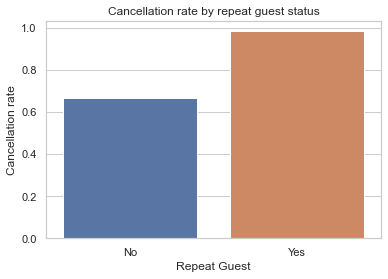

In [153]:
cancellation_rate_guest = dt_hotel.groupby('repeated_guest')['booking_status'].mean().reset_index()

sns.barplot(x='repeated_guest', y='booking_status', data=cancellation_rate_guest)

plt.xlabel('Repeat Guest')
plt.ylabel('Cancellation rate')
plt.xticks([0,1], ['No', 'Yes'])
plt.title('Cancellation rate by repeat guest status')
plt.show() 

#Maybe re-check this data

- Certain months are more or less likely to experience cancellations, indicating that seasonality may play a role in customer behavior. 

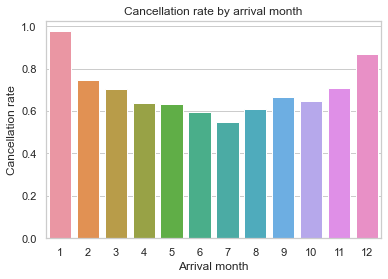

In [154]:
cancellation_rate_month = dt_hotel.groupby('arrival_month')['booking_status'].mean().reset_index()
sns.barplot(x='arrival_month', y='booking_status', data=cancellation_rate_month)
plt.xlabel('Arrival month')
plt.ylabel('Cancellation rate')
plt.title('Cancellation rate by arrival month')
plt.show()

Based on the information provided, some potential general recommendations for the hotel could include:

- Encouraging customers to make special requests, as no_of_special_requests was identified as the most important predictor in your model.
- Providing incentives or discounts for repeat customers, as repeated_guest was identified as an important predictor.
- Ensuring that adequate car parking spaces are available for customers who require them, as required_car_parking_space was identified as an important predictor.
- Offering a variety of room types to customers, as room_type_reserved was identified as an important predictor.
- Considering the impact of arrival month on bookings, as arrival_month had a relatively high importance score of 1.070.
- Paying attention to the number of adults and children in each booking, as no_of_children and no_of_adults were identified as important predictors.

Top 5 factors that affect whether customers cancel their booking, in order of importance:
	
- 'no_of_previous_bookings_not_canceled': Customers who have previously made bookings that were not canceled are less likely to cancel their booking.
- 'required_car_parking_space': Customers who require a car parking space are more likely to cancel their booking.
- 'room_type_reserved': Customers who reserve a certain room type are more likely to cancel their booking.
- 'repeated_guest': Repeat guests are less likely to cancel their booking.
- 'arrival_month': Customers who book during certain months are more or less likely to cancel their booking, depending on the specific month.